In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import cv2
import random

import solt
import solt.transforms as slt

In [2]:
def display_subfig(ax, img, kpts):
    ax.imshow(img)
    for k in kpts:
        ax.add_patch(patches.Circle(k, radius=4, color='r'))

    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_img_w_keypoints(img, kpts):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1,1,1)
    display_subfig(ax, img, kpts)
    plt.show()

In [3]:
img = cv2.imread('data/kaggle_cats_img.jpg')[:375]
kpts = np.loadtxt('data/kaggle_cats_keypoints.cat')[1:].reshape((9, 2))
kpts = kpts[~np.any(kpts <0, 1)] # for demo purposes, we'll remove the landmark with the negative coordintaes

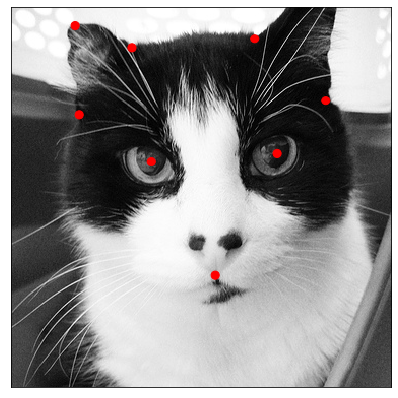

In [4]:
plot_img_w_keypoints(img, kpts)

In [5]:
stream = solt.Stream([
    slt.Flip(axis=1, p=0.5),
    solt.SelectiveStream([
        slt.Rotate(angle_range=(-45, -45), p=1),  
        slt.Rotate90(1, p=1),    
        slt.Rotate(angle_range=(45, 45), p=1),    
    ]),
    solt.SelectiveStream([
        slt.GammaCorrection(gamma_range=0.5, p=1),
        slt.Noise(gain_range=0.01, p=1),
        slt.Blur()    
    ], n=3),
    slt.Projection(affine_transforms=solt.Stream([
        slt.Rotate(angle_range=(-45, 45), p=1),
        slt.Scale(range_x=(0.8, 1.5), range_y=(0.8, 1.5), p=1, same=False)
    ]), v_range=(1e-4, 1e-3), p=1),
    slt.Pad((380, 380)),
    slt.Crop((350, 350)),
    solt.SelectiveStream([
        slt.CutOut(40, p=1),
        slt.CutOut(30, p=1),
        slt.CutOut(20, p=1),
        slt.CutOut(40, p=1),
        solt.Stream(),
    ], n=3),
])

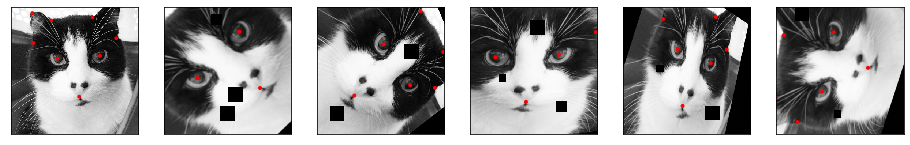

In [6]:
fig = plt.figure(figsize=(16,16))
n_augs = 6


random.seed(42)
for i in range(n_augs):
    img_aug, kpts_aug = stream({'image': img, 'keypoints': solt.Keypoints(kpts, height=img.shape[0], width=img.shape[1])}, return_torch=False).data

    ax = fig.add_subplot(1,n_augs,i+1)
    if i == 0:
        display_subfig(ax, img, kpts)  
    else:
        display_subfig(ax, img_aug, kpts_aug.data) 
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('results/cats.png', bbox_inches='tight')
plt.show()